<a href="https://colab.research.google.com/github/Elizaveta55/DS/blob/master/FinalExam_Lab_version2_minor_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Final Exam Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Data Preprocessing (5 points)
  2. Conditional Generative adversarial network definition (5 points)
  3. Conditional Generative adversarial network training (10 points)
  4. Text explainer implemetation using Lime or Shap (5 bonus points)
```

<hr>

## The Dataset

For this task the 20 newsgroups text dataset is used. [LINK](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

import nltk, string, re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Available device : {device}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Available device : cuda


## Task 1: Preprocessing of Dataset (5 points)



1.  Loading and cleaning of Text data:
    * Choose 4 categories from the dataset  
    * Implement a method `clean_text` which will take text then make text lowercase, remove punctuation, whitespaces and stopwords
    * Plot the distribution of classes/categories

In [2]:
categories = ['sci.med', 'comp.windows.x', 'alt.atheism', 'misc.forsale']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_valid = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))


In [5]:
print(newsgroups_train.data)

['I hear George Bush (remember him?) will receive an honors degree from\nsome Kuwaiti University for contributing to certain Kuwaiti interests\nnot too long ago.  Do you think it would add much to his resume? ;-)\n\n\n\n', 'Hi,\n\n\tI have a Humminbird HDR200 Depth Sounder for sale. It\nhas been used for 1 season on my sailboat. \n\t\n\tAll parts are included as well as the installation\ninstructions. It is even packed in the original box it came in. There\nis no damage to the unit or the transducer. In fact, the transducer\nwas mounted *inside* the hull in a piece of pipe glued to the hull.\nSo it led a "sheltered" life. The transducer can be mounted either inside\nthe hull as I did, or on the transom. It cannot be placed in a hole\ndrilled into your hull.\n\n\tIt is fully waterproof and fits into a 2" hole in a bulkhead\n(that\'s where I had it installed) or into a standard dashboard on a\npowerboat. It reads depth to 199\' and has a backlit LCD display. It has\nan adjustable shallow

In [19]:
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def clean_text(text):
    """ Function to perform common NLP pre-processing tasks. """
    # make lowercase
    text.lower()

    # remove punctuation
    text = re.sub(r'[^\w\s]','',text)

    # remove numbers
    text = re.sub(r'[\d+]','',text)

    # remove whitespaces
    text = re.sub(r'[\s+]',' ',text)

    # remove stopwords
    # remove short words
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words and len(w)>3] 
    output = ""
    # filtered_sentence = [] 
    # for w in word_tokens: 
    #     if w not in stop_words: 
    #         filtered_sentence.append(w) 
    return ' '.join([str(elem) for elem in filtered_sentence])

In [20]:
train_sentences = []
validation_sentences = []

train_labels = []
validation_labels = []


# Clean training sentences
for id in range(len(newsgroups_train.data)):
    text = clean_text(newsgroups_train.data[id])
    label = newsgroups_train.target[id]
    if text:
        train_sentences.append(text)
        train_labels.append(label)

# Clean validation sentences
for id in range(len(newsgroups_valid.data)):
    text = clean_text(newsgroups_valid.data[id])
    label = newsgroups_valid.target[id]
    if text:
        validation_sentences.append(text)
        validation_labels.append(label)

In [21]:
print(train_sentences)

['hear George Bush remember receive honors degree Kuwaiti University contributing certain Kuwaiti interests long think would much resume', 'Humminbird Depth Sounder sale used season sailboat parts included well installation instructions even packed original came There damage unit transducer fact transducer mounted inside hull piece pipe glued hull sheltered life transducer mounted either inside hull transom placed hole drilled hull fully waterproof fits hole bulkhead thats installed standard dashboard powerboat reads depth backlit display adjustable shallow water alarm built changing instruments another manufacturer outputs NMEA information This little depth sounder works fine stable usually priced catalogs paid first takes best offer John Miller', 'Seconded cycle work could damned cars cretinous drivers road would', 'Folks part selfintroduction trying simple icon animation sort like icondoit mswindows Changing applications icon fairly simple widget XtSetValues XtNiconifyPixmap whateve

## Create vocabulary

In [22]:
# Create tokenizer
en_tokenizer = get_tokenizer('spacy', language='en')

# Create vocabulary
def build_vocab(sentences, tokenizer):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer(sentence))
    return Vocab(counter, specials=['<unk>', '<pad>'])

vocabulary = build_vocab(train_sentences, en_tokenizer)

## Add padding 

In [23]:
max_len = 128

# Add Padding 
def create_dataset(sentences, labels, en_tokenizer, vocab, max_len=128):
    res = []
    for sentence in sentences:
        sentence_tokens = [vocab[token] for token in en_tokenizer(sentence)]
        if len(sentence_tokens) <= max_len:
            sentence_tokens = sentence_tokens + [vocab['<pad>']]*(max_len-len(sentence_tokens))
        else:
            sentence_tokens = sentence_tokens[:max_len]
        sentence_tensor = torch.tensor(sentence_tokens,dtype=torch.long)
        res.append(sentence_tensor)
        
    return TensorDataset(torch.stack(res),torch.from_numpy(np.array(labels)))

BATCH_SIZE = 128
PAD_IDX = vocabulary['<pad>']

train_dataset = create_dataset(train_sentences,train_labels, en_tokenizer, vocabulary)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = create_dataset(validation_sentences, validation_labels, en_tokenizer, vocabulary)

In [31]:
len(train_dataset)

2210

In [33]:
train_dataset.tensors[1].shape

tensor([1, 2, 0,  ..., 2, 3, 1])

In [37]:
train_dataset.tensors[0][0]

tensor([  797,  1535,  2792,   538,   674, 26628,  2213,  8394,   179,  5960,
          304,  8394,  3727,    91,    15,     4,    23,  4718,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

## Task 2: Conditional Generative adversarial network definition (5 points)

1.  Models Definition:
    * Define the Generator & Discriminator network (Achitecture of your choice) 

In [ ]:
# TODO: Implement the Generator & Discriminator class
class Generator(nn.Module):
    # initializers
    def __init__(self,output_dim, noise_dim=32):
        super(Generator, self).__init__()

        self.label_embedding = nn.Embedding(4, 4)
        self.sent_embeddint = nn.Embedding(len(vocabulary), 252)

        self.model = nn.Sequential(
            nn.Linear(252+4, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 128),
            nn.Tanh()
        )
        

    # forward method. Condition is should be incorporated to the model input 
    def forward(self, data, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        return img.view(img.size(0), 128)

class Discriminator(nn.Module):
    # initializers
    def __init__(self,input_size):
        super(Discriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(4, 4)
        self.sent_embedding = nn.Embedding(len(vocabulary), 252)

        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    # forward method. Note: Condition is should be incorporated to the model input
    def forward(self, data, label):
      d_in = torch.cat((self.sent_embedding(data[0]), self.label_embedding(label)), -1)
      return self.model(d_in[0])


D = Discriminator(input_size=256).to(device).float()
G = Generator(output_dim=256).to(device).float()

print(G)
print()
print(D)

## Task 3: Conditional Generative adversarial network training (10 points)

* Implement the Conditional Generative adversarial network training procedure 
* Define the optimizers for Generator and Discriminator network
* Define the loss functions
* Add Tensorboard to log the Generator and Discriminator loss (for both Training and Validation). For discriminator the loss on fake samples and real samples should be logged separately 

**NOTE:** It is not important that the loss decreases during the training loop for this task. It is important that the training procedure is correctly implemented

In [42]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

writer = SummaryWriter()

# params
learning_rate = 0.0001
n_epochs = 10
noise_dim = 4

# TODO: Create optimizers for the discriminator and generator
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

#fixed noise for validation 
fixed_noise = torch.normal(0,1, (len(validation_dataset),noise_dim), dtype=torch.float, device=device)

criterion = nn.BCELoss()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
## TODO: Implement the training procedure and log train & validation loss using tensorboard
from torch import autograd
from torch.autograd import Variable

for epoch in range(n_epochs):
    for x,y in enumerate(train_loader):
        real_x = Variable(y[0]).cuda()
        print(real_x)
        labels = Variable(y[1]).cuda()
        
        print(labels)
        G.train()
        batch_size = len(y)

        d_optimizer.zero_grad()
        real_validity = D(real_x, labels)
        real_loss = criterion(real_validity, Variable(torch.ones(batch_size))[0].cuda())
        
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        fake_images = G(z, fake_labels)
        fake_validity = D(fake_images, fake_labels)
        fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        d_loss = d_loss.data[0]

        g_optimizer.zero_grad()
        z = Variable(torch.randn(batch_size, 128)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 4, batch_size))).cuda()
        fake_images = G(z, fake_labels)
        validity = D(fake_images, fake_labels)
        g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
        g_loss.backward()
        g_optimizer.step()
        g_loss = g_loss.data[0]


RuntimeError: ignored

## Launch Tensorboard

In [ ]:
%tensorboard --logdir ./runs

## Task 4: (Optional): Text explainer implemetation using Lime or Shap (5 bonus points)

Using the [20 newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) text dataset is used.
Create a simple(i.e Decision tree, Random Forest) multi-class classifier and explain the classifiers predictions with the help of LIME or SHARP. 

**Note:** Use TF-IDF for feature extraction

In [67]:
!pip install lime

import lime
import sklearn
import numpy as np
import sklearn.ensemble
import sklearn.metrics
from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups


     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=97dfc2b2cb9fe3f84d807051e7462179c026399276a08f968c33616b1cfa7031
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [68]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

clf = None

In [69]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

In [70]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [72]:
pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='weighted')

0.7715653816022991

In [79]:
text_classification_pipeline = make_pipeline(vectorizer, rf)
print(text_classification_pipeline.predict_proba([newsgroups_test.data[0]]))

[[0.026 0.076 0.044 0.06  0.102 0.038 0.05  0.086 0.044 0.092 0.018 0.034
  0.096 0.048 0.052 0.026 0.024 0.014 0.03  0.04 ]]


In [75]:
from lime.lime_text import LimeTextExplainer
#class_names = newsgroups_train.categories
#explainer = LimeTextExplainer(class_names=class_names)
explainer = LimeTextExplainer()

In [82]:
import numpy as np


idx = 10
exp = explainer.explain_instance(newsgroups_test.data[idx], text_classification_pipeline.predict_proba, num_features=6)
print(f'Document id: {idx}')
print('Probability =', text_classification_pipeline.predict_proba([newsgroups_test.data[idx]]))
print('Predicted class number =', np.argmax(text_classification_pipeline.predict_proba([newsgroups_test.data[idx]])))
print(f'True class: {newsgroups_test.target[idx]}')

Document id: 10
Probability = [[0.01  0.1   0.474 0.062 0.036 0.062 0.062 0.012 0.014 0.014 0.018 0.002
  0.056 0.016 0.022 0.012 0.01  0.004 0.012 0.002]]
Predicted class number = 2
True class: 2


In [83]:
exp.as_list()

[('ftp', 0.02849446531867894),
 ('Windows', -0.015924963105782886),
 ('cica', -0.014588251619548388),
 ('pub', 0.008679739774886919),
 ('Organization', -0.00857279627655093),
 ('an', -0.00808945988122868)]

In [86]:
print('Original prediction:', rf.predict_proba(test_vectors[idx]))
tmp = test_vectors[idx].copy()
tmp[0,vectorizer.vocabulary_['Windows']] = 0
tmp[0,vectorizer.vocabulary_['pub']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp))
print('Difference:', rf.predict_proba(tmp) - rf.predict_proba(test_vectors[idx]))

Original prediction: [[0.01  0.1   0.474 0.062 0.036 0.062 0.062 0.012 0.014 0.014 0.018 0.002
  0.056 0.016 0.022 0.012 0.01  0.004 0.012 0.002]]
Prediction removing some features: [[0.012 0.118 0.244 0.092 0.062 0.078 0.092 0.022 0.02  0.026 0.026 0.006
  0.084 0.03  0.028 0.016 0.01  0.01  0.016 0.008]]
Difference: [[ 0.002  0.018 -0.23   0.03   0.026  0.016  0.03   0.01   0.006  0.012
   0.008  0.004  0.028  0.014  0.006  0.004  0.     0.006  0.004  0.006]]


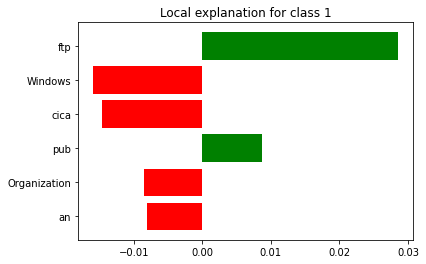

In [87]:
%matplotlib inline
fig = exp.as_pyplot_figure()

## <center>Solution should be pushed to github and link to github submitted to Moodle</center>